# Simulation of ARCS powder experiment

In [1]:
# some goodies
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np, histogram.hdf as hh, histogram as H

## Create workflow

In [ ]:
/SNS/users/

In [2]:
# Change me
workdir = "/SNS/users/lj7/simulations/ARCS/powder-demo2"
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/lj7/simulations/ARCS/powder-demo2


In [3]:
!mcvine workflow powder --instrument=ARCS --sample=V --workdir=mysim

/SNS/users/lj7/software/miniconda2/envs/mcvine/lib/python2.7/site-packages/mcvine/deployment_info.py:41: UserWarning: Neither environment variable MCVINE_DIR nor DANSE_DIR was defined. Assumed that it is /SNS/users/lj7/software/miniconda2/envs/mcvine.
  warnings.warn(msg)


In [4]:
!ls mysim/

beam	    debug-scatter  reduce2iqe	   scatter  sss.pml
create-nxs  Makefile	   sampleassembly  sss	    test-scatter


## Beam simulation

In [10]:
!cat mysim/beam/run-beam.sh

#!/usr/bin/env bash

mcvine instruments arcs beam --keep-in-cache --use-cache E=100 --ncount=1e5

In [15]:
%%file mysim/beam/run-beam.sh
#!/usr/bin/env bash

mcvine instruments arcs beam --keep-in-cache --use-cache -E=100 --ncount=1e5


Writing mysim/beam/run-beam.sh


IOError: [Errno 2] No such file or directory: 'mysim/beam/run-beam.sh'

In [11]:
%cd {workdir}/mysim/beam

/SNS/users/lj7/simulations/ARCS/powder-demo2/mysim/beam


In [12]:
!./run-beam.sh

/SNS/users/lj7/software/miniconda2/envs/mcvine/lib/python2.7/site-packages/mcvine/deployment_info.py:41: UserWarning: Neither environment variable MCVINE_DIR nor DANSE_DIR was defined. Assumed that it is /SNS/users/lj7/software/miniconda2/envs/mcvine.
  warnings.warn(msg)
Generating pml for arcs beam instrument...
 -> running mcvine instruments arcs m2s --with_moderator_angling=True --E=70.0 --T0_nu=60.0 --emission_time=-1.0 --fermi_nu=600.0 --fermi_chopper=100-1.5-SMI --- -dump-pml=yes -h...
moderator emission time for neutron of energy 70.0 is 6.1060677979e-07
moderator emission time for neutron of energy 70.0 is 6.1060677979e-07
/SNS/users/lj7/software/miniconda2/envs/mcvine/lib/python2.7/site-packages/mcni/pyre_support/MpiApplication.py:87: UserWarning: no point to run in parallel mode when using just one node
  warnings.warn("no point to run in parallel mode when using just one node")
------------------------------------------------------------
* Instrument simulation application 

In [13]:
!ls out

ienergy.h5  ix_divy.h5	iy_divy.h5	      neutrons
itof.h5     ix_y.h5	mon1-itof-focused.h5  props.json
ix_divx.h5  iy_divx.h5	mon2-itof-focused.h5  rank0-step0


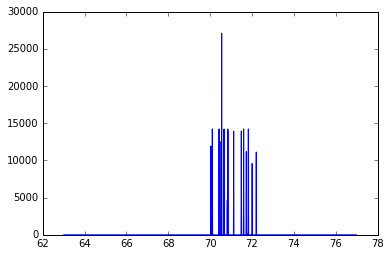

In [14]:
ie = hh.load("out/ienergy.h5")
plt.plot(ie.energy, ie.I)

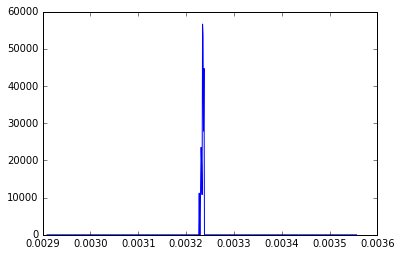

In [16]:
m1 = hh.load("out/mon1-itof-focused.h5")
plt.plot(m1.tof, m1.I)

## Scattering

In [17]:
%cd {workdir}/mysim
!ls

/SNS/users/lj7/simulations/ARCS/powder-demo2/mysim
beam	    debug-scatter  reduce2iqe	   scatter  sss.pml
create-nxs  Makefile	   sampleassembly  sss	    test-scatter


In [18]:
!cat scatter

#!/usr/bin/env bash

LAUNCHER=`python -c "from mcni.pyre_support.MpiApplication import mpi_launcher_choice as l; print l"`
rm -rf out && ./sss --ncount=1e5 --multiple-scattering=on --$LAUNCHER.nodes=2 --buffer_size=10000

#--journal.debug.phonon_incoherent_inelastic_kernel


In [19]:
%%file scatter
#!/usr/bin/env bash

LAUNCHER=`python -c "from mcni.pyre_support.MpiApplication import mpi_launcher_choice as l; print l"`
rm -rf out && ./sss --ncount=1e6 --multiple-scattering=off --$LAUNCHER.nodes=10 --buffer_size=10000


Overwriting scatter


In [20]:
!chmod +x scatter sss reduce2iqe create-nxs
!make

./scatter </dev/null >log.scatter 2>&1
./create-nxs </dev/null >log.create-nxs 2>&1
cp arcs-sim.nxs arcs-sim-wEidata.nxs &&\
mcvine instruments arcs nxs populate_metadata --type=Ei --nxs=arcs-sim-wEidata.nxs --beam_outdir=beam/out
/SNS/users/lj7/software/miniconda2/envs/mcvine/lib/python2.7/site-packages/mcvine/deployment_info.py:41: UserWarning: Neither environment variable MCVINE_DIR nor DANSE_DIR was defined. Assumed that it is /SNS/users/lj7/software/miniconda2/envs/mcvine.
  warnings.warn(msg)
./reduce2iqe >log.reduce 2>&1


plot z in (0, 0.0001)


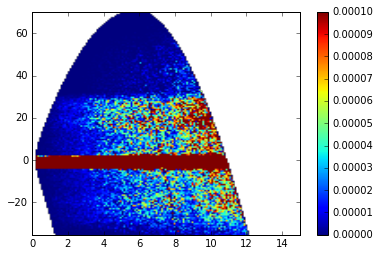

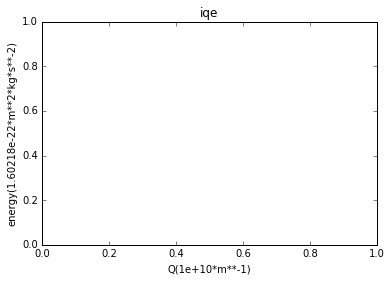

In [22]:
iqe = hh.load("iqe.h5")
H.plot(iqe, min=0, max=1e-4)

In [23]:
!cat ./sampleassembly/sampleassembly.xml

<SampleAssembly name="bcc V powder sample assembly">

  <PowderSample name="V" type="sample">
    <Shape>
      <block width="50*mm" height="50*mm" thickness="1.2*mm" />
    </Shape>
    <Phase type="crystal">
      <ChemicalFormula>V</ChemicalFormula>
      <xyzfile>V.xyz</xyzfile>
    </Phase>
  </PowderSample>

  <LocalGeometer registry-coordinate-system="InstrumentScientist">
    <Register name="V" position="(0,0,0)" orientation="(0,0,0)"/>
  </LocalGeometer>

</SampleAssembly>


## Change sample kernel

In [24]:
!make clean
!ls

rm -rf out work-* log.* *~ *.h5 *.nxs
beam	    debug-scatter  reduce2iqe	   scatter  sss.pml
create-nxs  Makefile	   sampleassembly  sss	    test-scatter


In [25]:
!cat sampleassembly/V-scatterer.xml

<?xml version="1.0"?>

<!DOCTYPE scatterer>

<!-- mcweights: monte-carlo weights for 3 possible processes:
     absorption, scattering, transmission -->
<homogeneous_scatterer mcweights="0, 1, 0">

  <KernelContainer average="yes">

    <Phonon_IncoherentElastic_Kernel dw_core='0.00701434948808*angstrom**2'>
    </Phonon_IncoherentElastic_Kernel>

    <Phonon_IncoherentInelastic_Kernel>
      <LinearlyInterpolatedDOS idf-data-path="phonons/DOS">
      </LinearlyInterpolatedDOS>
    </Phonon_IncoherentInelastic_Kernel>

    <MultiPhonon_Kernel Qmax="15/angstrom">
      <LinearlyInterpolatedDOS idf-data-path="phonons/DOS"/>
    </MultiPhonon_Kernel>

  </KernelContainer>
</homogeneous_scatterer>



In [26]:
%%file sampleassembly/V-scatterer.xml
<?xml version="1.0"?>

<!DOCTYPE scatterer>

<!-- weights: absorption, scattering, transmission -->
<homogeneous_scatterer mcweights="0, 1, 0">
  
  <E_Q_Kernel 
     E_Q="30+10*sin(Q)" 
     S_Q="1" 
     Qmin="0./angstrom"
     Qmax="10./angstrom"
     />
  
</homogeneous_scatterer>

Overwriting sampleassembly/V-scatterer.xml


In [27]:
!make

./scatter </dev/null >log.scatter 2>&1
./create-nxs </dev/null >log.create-nxs 2>&1
cp arcs-sim.nxs arcs-sim-wEidata.nxs &&\
mcvine instruments arcs nxs populate_metadata --type=Ei --nxs=arcs-sim-wEidata.nxs --beam_outdir=beam/out
/SNS/users/lj7/software/miniconda2/envs/mcvine/lib/python2.7/site-packages/mcvine/deployment_info.py:41: UserWarning: Neither environment variable MCVINE_DIR nor DANSE_DIR was defined. Assumed that it is /SNS/users/lj7/software/miniconda2/envs/mcvine.
  warnings.warn(msg)
./reduce2iqe >log.reduce 2>&1


plot z in (0, 0.01)


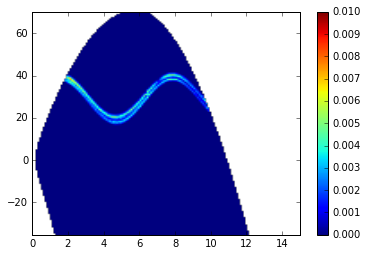

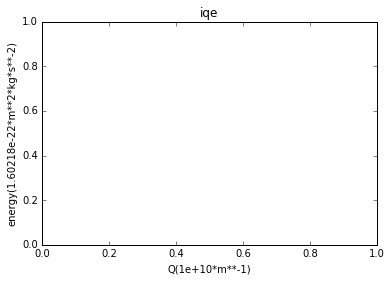

In [28]:
iqe = hh.load("iqe.h5")
H.plot(iqe, min=0, max=1e-2)

#### hello world
* hello
* world

$\alpha$